# Diffusion Models

Diffusion models are generative models used primarily for image synthesis and other computer vision tasks. They are trained to **progressively add random noise** to data (the *forward diffusion* process) and then **learn to reverse** that process to generate high-quality samples from noise.

## Before diffusion: GANs and VAEs

**Generative Adversarial Networks (GANs).**
GANs consist of two models trained together: a **generator**, which tries to produce realistic “fake” images, and a **discriminator**, which tries to distinguish generated images from real ones. Training is adversarial—the generator improves by learning to fool the discriminator.

**Variational Autoencoders (VAEs).**
A VAE encodes an input image into a **latent space** (a low-dimensional vector capturing salient features) and then decodes it back to reconstruct the image. Unlike standard autoencoders, VAEs are **probabilistic**: instead of encoding to a single fixed latent vector (z), they learn a **distribution** over latent variables (e.g., (p(z \mid x))) and sample from it during training and generation.

> This exercise is not about implementing GANs or VAEs, so we won’t dive into their details here.

### Further reading

* [What are generative adversarial networks (GANs)?](https://www.ibm.com/think/topics/generative-adversarial-networks)
* [Generative Adversarial Network (GAN) — GeeksforGeeks](https://www.geeksforgeeks.org/deep-learning/generative-adversarial-network-gan/)
* [What is a variational autoencoder?](https://www.ibm.com/think/topics/variational-autoencoder)
* [Variational AutoEncoders — GeeksforGeeks](https://www.geeksforgeeks.org/machine-learning/variational-autoencoders/)

## Rise of diffusion models

In 2020, the paper **[Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239)** introduced diffusion probabilistic models (DDPMs), which use the diffusion mechanism to generate images. Since then, diffusion has become one of the most popular families of generative models. Notable examples include **[SORA-1](https://openai.com/index/video-generation-models-as-world-simulators/)**, **[SORA-2](https://openai.com/index/sora-2/)**, **[DALL·E 2](https://openai.com/index/dall-e-2/)**, and the **Stable Diffusion** family.

You can explore thousands of stable diffusion models on **[Hugging Face](https://huggingface.co/models?other=stable-diffusion)**.

What is interesing, there are also new types of diffusion models: Diffusion LLMs to generate text faster then autoregresive models. Check [Inception Diffusion LLM](https://www.inceptionlabs.ai/).

---

This course mainly base on the following resources:

* **Tutorial:** [Diffusion Model from Scratch in PyTorch (DDPM)](https://medium.com/data-science/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946)
* **Original paper:** [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239)


In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import lightning as L

from torchvision.utils import make_grid
import wandb

from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

wandb.login()  # Log in to your W&B account
L.seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


wandb: Currently logged in as: kapiotrow (deep-neural-network-course) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Seed set to 42


cuda


# Diffusion model overview

A diffusion model has two phases:
1. **Forward (diffusion) process** – gradually corrupts clean data with noise until it becomes pure Gaussian noise.
2. **Reverse (denoising) process** – learns to invert that corruption and turn noise back into data.

---

## Forward diffusion process

The forward diffusion process takes a clean data sample $x_0$ (e.g. an image) and step by step adds Gaussian noise until it becomes nearly pure noise $x_T$.

This process is modeled as a Markov chain. That means each noisy sample $x_t$ depends only on the previous one $x_{t-1}$, not on the full history:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}\left(\sqrt{1 - \beta_t}\, x_{t-1}, \ \beta_t I \right)
$$

Where:
- $\beta_t$ controls how much noise we add at timestep $t$.
- Small $\beta_t$ → a tiny amount of noise. Large $\beta_t$ → more noise.
- After many steps $t = 1 \dots T$, the data loses structure and becomes close to pure Gaussian noise.

Instead of simulating all steps one by one, we can directly sample the noised version at any timestep $t$ using a reparameterization. Define:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$

Then we can write:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \varepsilon
$$

with $\varepsilon \sim \mathcal{N}(0, I)$.

**Interpretation:**
- $\bar{\alpha}_t$ acts like a signal-to-noise ratio at step $t$.
  - Early (small $t$): $\bar{\alpha}_t \approx 1$ → mostly clean signal.
  - Late (large $t$): $\bar{\alpha}_t \approx 0$ → mostly noise.
- This closed-form lets us sample $x_t$ at any timestep $t$ in one shot, without running every previous step. This is important for training efficiency.

---

## Reverse diffusion process

The reverse diffusion process is the generative step. We start from pure noise $x_T \sim \mathcal{N}(0, I)$ and try to iteratively denoise it back into something that looks like real data.

In an ideal world, we would sample

$$
q(x_{t-1} \mid x_t)
$$

which answers: “given this noisy image $x_t$, what should the slightly cleaner image $x_{t-1}$ look like?”

But the true reverse distribution $q(x_{t-1} \mid x_t)$ is intractable: technically solvable, but requiring infinite time to compute.

So instead we train a neural network $\varepsilon_\theta(x_t, t)$ to predict the noise that was added at step $t$. If we know the noise, we can remove it and step from $x_t$ to an estimate of $x_{t-1}$. This defines a learned reverse process

$$
p_\theta(x_{t-1} \mid x_t)
$$

which we use to walk backward from $x_T$ to something that looks like $x_0$.

**Intuition:**
- Forward: slowly add noise.
- Reverse: learn how to remove that noise step by step.
- After training, we can generate a *new* image by starting from random noise and denoising repeatedly.

---

## Loss function for training

Training tries to make the learned reverse process $p_\theta$ match the true forward process $q$. The full derivation is written as a variational lower bound (VLB) and involves KL divergences between Gaussians at each step.

It is commonly described in terms of three terms: $L_T$, $L_t$, and $L_0$.

- **$L_T$**  
  KL divergence between $q(x_T \mid x_0)$ and $p_\theta(x_T)$.  
  Intuition: does the model's starting distribution at $t = T$ match pure Gaussian noise?  
  This can usually be treated as a constant because $x_T$ is basically standard Gaussian.

- **$L_t$**  
  KL divergence between the *true* reverse step $q(x_{t-1} \mid x_t, x_0)$ and the *learned* reverse step $p_\theta(x_{t-1} \mid x_t)$.  
  This measures how well the model denoises at each timestep.

- **$L_0$**  
  Negative log-likelihood of reconstructing the original sample $x_0$ from $x_1$:  
  $-\log p_\theta(x_0 \mid x_1)$.  
  This tells us how well the final denoised output matches real data.

---

### Practical simplification

All of that math can be simplified to a very convenient training loss.

During training we:
1. Take a real sample $x_0$.
2. Sample a random timestep $t$.
3. Generate $x_t$ using the closed form
   $$
   x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \varepsilon
   $$
   with known noise $\varepsilon$.
4. Ask the model to predict that noise: $\varepsilon_\theta(x_t, t)$.

Then we optimize a simple mean squared error (MSE):

$$
\mathcal{L}_\text{simple}(\theta)
= \mathbb{E}_{t, x_0, \varepsilon}
\Big[
\| \varepsilon - \varepsilon_\theta(x_t, t) \|^2
\Big]
$$

So the model is literally trained to answer:  
**"What noise was added here?"**

---

## Important to remember

<img src = "https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab8_diffusion/figures/algorithms.png" alt="Algorithms" width="600">

- **Forward (diffusion) process:**  
  We corrupt clean data into noise:
  $$
  x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \varepsilon
  $$
  where $\bar{\alpha}_t$ decreases over time → less signal, more noise → $x_T$ is almost pure Gaussian noise.

- **Reverse (denoising) process:**  
  A neural network predicts the noise $\varepsilon_\theta(x_t, t)$ so we can remove it and step from $x_t$ to $x_{t-1}$. Repeating this turns random noise into a realistic sample.


- **Training loop (per batch image):**
  1. Sample timestep $t$.
  2. Create a noisy version $x_t$ from $x_0$.
  3. Train the model to predict the noise that was added.

- **Sampling / generation:**
  1. Start from random Gaussian noise.
  2. Apply the model step by step to denoise.
  3. After all steps, you get a generated image.

**Core idea:** diffusion learns how to undo noise.


### Implementation

Let's start by implementing the **`DDPM_Scheduler`** class.
This class will initialize the parameters $\beta$ and $\hat{\alpha}$ used during training and sampling.

In the original DDPM paper, *Ho et al.* used a **linear variance schedule** with 1,000 steps, where $\beta_1 = 1 \times 10^{-4}$ and $\beta_T = 0.02$.
Later studies found that alternative schedules — such as **cosine schedules** or even **learned schedules**  — can improve both performance and efficiency. But we will focus on basic one.

**Steps to implement:**

1. Initialize `self.beta` as a linearly spaced tensor (`torch.linspace`) over the number of timesteps, ranging from `1e-4` to `0.02`.
2. Compute $\alpha = 1 - \beta$.
3. Initialize `self.alpha` as the **cumulative product** of $\alpha$ using `torch.cumprod`. Set requires_grad as `False`.

We can define `forward` function, that takes parameter `t` and returns `self.beta` and `self.alpha` for timestamp `t`. 


In [2]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps)
        alpha = 1.0 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

## Model architecture (implementation notes)

We now define the denoising network. Following the DDPM paper, the core model is a **U-Net** with:
- **Residual convolutional blocks** (Wide-ResNet–style): two $3\times3$ convs per block, **GroupNorm** instead of BatchNorm, **SiLU** nonlinearity, and **Dropout**.
- **Self-attention blocks** at lower spatial resolutions (e.g., at $16\times16$ for inputs of $32\times32$ or $256\times256$). Attention helps the model capture long-range dependencies that plain convolutions might miss.

We’ll first implement two building blocks:
1. `ResnetBlock2D` — a residual conv block that also injects **time embeddings**.
2. `AttentionBlock` — a 2D self-attention block applied between down/up conv stages.

---

### `ResnetBlock2D` — residual block with time embedding

**Constructor arguments.**
- `C_in` *(int)*: input channel dimension.  
- `C_out` *(int)*: output channel dimension.  
- `C_emb` *(int)*: dimension of the **time embedding** that will be injected (described later).  
- `num_groups` *(int)*: number of groups for `GroupNorm`.  
- `dropout_p` *(float)*: dropout probability (e.g., `0.1` or `0.2`).

**Layers inside.**
- `GroupNorm(C_in)` → `Conv2d(C_in, C_out, 3×3, padding=1)`  
- `Linear(C_emb → C_out)` to project the time embedding  
- `GroupNorm(C_out)` → `Dropout(p=dropout_p)` → `Conv2d(C_out, C_out, 3×3, padding=1)`  
- `SiLU(inplace = True)` nonlinearity after each normalization (pre-activation style)

**Forward pass.**
1. Normalize and activate the input.
2. First conv.
3. Inject time embedding:  
   - Project: `emb = Linear(time_emb)`
   - Broadcast and add: `h = h + emb[:, :, None, None]`
4. Normalize → dropout → activate → second conv:  
5. Residual add if `in` and `out` shapes match, else return output from second conv.

In [3]:
import torch
import torch.nn as nn

class ResnetBlock2D(nn.Module):
    def __init__(self,  
                 C_in: int, 
                 C_out: int,
                 C_emb: int, 
                 num_groups: int, 
                 dropout_p: float):
        
        super().__init__()
        
        # --- First normalization + conv ---
        self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C_in)
        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        
        # --- Time embedding projection ---
        self.time_emb_proj = nn.Linear(C_emb, C_out)
        
        # --- Second normalization + conv ---
        self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C_out)
        self.dropout = nn.Dropout(p=dropout_p)
        self.conv2 = nn.Conv2d(C_out, C_out, kernel_size=3, padding=1)
        
        # --- Nonlinearity ---
        self.nonlinearity = nn.SiLU(inplace=True)

    def forward(self, x, embeddings):
        # Residual input
        residual = x
        
        # --- First normalization and conv ---
        h = self.norm1(x)
        h = self.nonlinearity(h)
        h = self.conv1(h)
        
        # --- Inject time embedding ---
        emb = self.time_emb_proj(embeddings)
        h = h + emb[:, :, None, None]
        
        # --- Second normalization and conv ---
        h = self.norm2(h)
        h = self.dropout(h)
        h = self.nonlinearity(h)
        h = self.conv2(h)
        
        # --- Residual connection ---
        return h + residual if h.shape == residual.shape else h


### `AttentionBlock` — multi-head self-attention for 2D features

**Constructor arguments.**
- `C` *(int)*: channel dimension for input/output.  
- `num_heads` *(int)*: number of attention heads; must divide `C`.  
- `num_groups` *(int)*: number of groups for `GroupNorm`.  
- `dropout_p` *(float)*: attention dropout probability.

**Layers inside.**
- `GroupNorm(num_groups, C)`  
- `Linear(C → C)` for **query**, **key**, and **value** projections (separate layers)  
- `Linear(C → C)` output projection (`proj_attn`)

**Forward pass.**
1. Normalize the input.  
2. Flatten spatial dims for QKV: first use `.view` to merge `H*W` into `L`, then `.permute` to get `(B, L, C)` from `(B, C, H, W)`.  
3. Project to Q, K, V using `x_flat` and the linear layers.  
4. Reshape for multi-head attention: `.view(B, L, num_heads, head_dim)` then `.permute(0, 2, 1, 3)` to obtain `(B, num_heads, L, head_dim)`.  
5. Compute attention with `F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p, is_causal=False)`.  
6. Combine heads: `.permute(0, 2, 1, 3).contiguous()` back to `(B, L, num_heads, head_dim)`, then `.view(B, L, C)`.  
7. Project the merged attention using the `proj_attn` linear layer.  
8. Unflatten to the image shape: `.permute(0, 2, 1)` to `(B, C, L)`, then `.reshape(B, C, H, W)`.


In [4]:
class AttentionBlock(nn.Module):
    def __init__(self, C: int, num_heads: int, num_groups: int, dropout_p: float):
        super().__init__()
        assert C % num_heads == 0, "C must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = C // num_heads
        self.dropout_p = dropout_p

        # --- Normalization ---
        self.group_norm = nn.GroupNorm(num_groups=num_groups, num_channels=C)

        # --- QKV projections ---
        self.query = nn.Linear(C, C)
        self.key = nn.Linear(C, C)
        self.value = nn.Linear(C, C)

        # --- Output projection ---
        self.proj_attn = nn.Linear(C, C)

    def forward(self, x):
        """
        Args:
            x: (B, C, H, W) - input feature map
        Returns:
            out: (B, C, H, W)
        """
        B, C, H, W = x.shape
        x = self.group_norm(x)

        # --- Flatten spatial dimensions ---
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, L, C)
        L = x_flat.shape[1]

        # --- QKV projections ---
        q = self.query(x_flat)
        k = self.key(x_flat)
        v = self.value(x_flat)

        # --- Reshape for multi-head attention ---
        q = q.view(B, L, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, H, L, d)
        k = k.view(B, L, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(B, L, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # --- Scaled dot-product attention ---
        attn = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout_p, is_causal=False
        )  # (B, H, L, d)

        # --- Merge heads ---
        attn = attn.permute(0, 2, 1, 3).contiguous().view(B, L, C)  # (B, L, C)

        # --- Output projection ---
        x_out = self.proj_attn(attn)

        # --- Reshape back to image format ---
        x_out = x_out.permute(0, 2, 1).reshape(B, C, H, W)

        return x_out

Now, using our ResNet and Attention block we will implement larger block for our U-Net, more precisly, DownBlock2D, UpBlock2D and MidBlock2D.

### `DownBlock2D` — encoder stage with optional attention

**Constructor arguments.**
- `C_in` *(int)*: input channels.  
- `C_out` *(int)*: output channels after this stage.  
- `C_emb` *(int)*: time-embedding dimension passed to `ResnetBlock2D`.  
- `num_groups` *(int)*: number of groups for `GroupNorm`.  
- `dropout_p` *(float)*: dropout probability in residual blocks.  
- `use_attn` *(bool)*: whether to insert an `AttentionBlock`.

**Layers inside.**
- `ResnetBlock2D(C_in → C_out)`  
- `ResnetBlock2D(C_out → C_out)`  
- `AttentionBlock(C_out, num_head=8)` *or* `Identity` (controlled by `use_attn`)  
- Downsample: `Conv2d(C_out → C_out, kernel=3, stride=2, pad=1)`

**Forward pass.**
1. Apply two residual blocks with time conditioning.  
2. Apply attention.  
3. Save the current feature map as **`skip`** for the U-Net skip connection.  
4. Downsample with a stride-2 conv.  
5. Return `(x, skip)`.

In [5]:
class DownBlock2D(nn.Module):
    def __init__(self, 
                 C_in, 
                 C_out, 
                 C_emb, 
                 num_groups, 
                 dropout_p, 
                 use_attn=False):
        
        super().__init__()
        self.use_attn = use_attn
        self.res1 = ResnetBlock2D(C_in,  C_out, C_emb, num_groups, dropout_p)
        self.res2 = ResnetBlock2D(C_out, C_out, C_emb, num_groups, dropout_p)
        
        if use_attn:
            self.attn = AttentionBlock(C_out, num_heads=8, num_groups=num_groups, dropout_p=dropout_p)
        else:
            self.attn = nn.Identity()
        self.down = nn.Conv2d(C_out, C_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x, emb):
        x = self.res1(x, emb)
        x = self.res2(x, emb)
        x = self.attn(x)
        skip = x
        x = self.down(x)
        return x, skip

### `UpBlock2D` — decoder stage with skip fusion and optional attention

**Constructor arguments.**
- `C_in` *(int)*: channels of the incoming **upsampled** stream.  
- `C_skip` *(int)*: channels from the encoder skip tensor (to be concatenated).  
- `C_out` *(int)*: output channels after this stage.  
- `C_emb` *(int)*: time-embedding dimension for `ResnetBlock2D`.  
- `num_groups` *(int)*: number of groups for `GroupNorm`.  
- `dropout_p` *(float)*: dropout probability in residual blocks.  
- `use_attn` *(bool)*: whether to insert an `AttentionBlock`.

**Layers inside.**
- Upsample `up`: Sequential with `Upsample(scale_factor=2, mode="nearest")` → `Conv2d(C_in → C_in, 3×3, pad=1)`  
- `ResnetBlock2D(C_in + C_skip → C_out)`  
- `ResnetBlock2D(C_out → C_out)`  
- `AttentionBlock(C_out, num_heads=8)` *or* `Identity` (controlled by `use_attn`)

**Forward pass.**
1. Upsample the input stream (nearest) and smooth with a 3×3 conv.  
2. If spatial sizes differ from the skip tensor `(x.shape[-2:] != skip.shape[-2:])`, **resize** with bilinear interpolation to match `(F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False))`.  
3. Concatenate channels: `cat([x, skip], dim=1)`.  
4. Apply two residual blocks with time conditioning.  
5. Apply attention.  
6. Return the refined feature map.

In [6]:
class UpBlock2D(nn.Module):
    def __init__(self, 
                 C_in, 
                 C_skip, 
                 C_out, 
                 C_emb, 
                 num_groups, 
                 dropout_p, 
                 use_attn=False):
        super().__init__()
        self.use_attn = use_attn

        # --- Upsampling ---
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(C_in, C_in, kernel_size=3, padding=1)
        )

        # --- Two residual blocks ---
        self.res1 = ResnetBlock2D(C_in + C_skip, C_out, C_emb, num_groups, dropout_p)
        self.res2 = ResnetBlock2D(C_out, C_out, C_emb, num_groups, dropout_p)

        # --- Optional attention ---
        if use_attn:
            self.attn = AttentionBlock(C_out, num_heads=8, num_groups=num_groups, dropout_p=dropout_p)
        else:
            self.attn = nn.Identity()

    def forward(self, x, skip, emb):
        # --- Upsample ---
        x = self.up(x)

        # --- Safety resize if necessary ---
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)

        # --- Concatenate with skip connection ---
        x = torch.cat([x, skip], dim=1)

        # --- Two ResNet blocks with time embedding ---
        x = self.res1(x, emb)
        x = self.res2(x, emb)

        # --- Optional attention ---
        x = self.attn(x)

        return x

### `MidBlock2D` — bottleneck with attention

**Constructor arguments.**
- `C` *(int)*: channel dimension throughout the mid block.  
- `C_emb` *(int)*: time-embedding dimension for `ResnetBlock2D`.  
- `num_groups` *(int)*: number of groups for `GroupNorm`.  
- `dropout_p` *(float)*: dropout probability in residual blocks.

**Layers inside.**
- `ResnetBlock2D(C → C)`  
- `AttentionBlock(C, num_heads=8)`  
- `ResnetBlock2D(C → C)`

**Forward pass.**
1. Residual block with time conditioning.  
2. Self-attention to inject global context.  
3. Second residual block with time conditioning.  
4. Return the bottleneck features.

In [7]:
class MidBlock2D(nn.Module):
    def __init__(self, C, C_emb, num_groups, dropout_p):
        super().__init__()
        # --- First ResNet block ---
        self.res1 = ResnetBlock2D(C, C, C_emb, num_groups, dropout_p)
        # --- Self-Attention block ---
        self.attn = AttentionBlock(C, num_heads=8, num_groups=num_groups, dropout_p=dropout_p)
        # --- Second ResNet block ---
        self.res2 = ResnetBlock2D(C, C, C_emb, num_groups, dropout_p)

    def forward(self, x, emb):
        x = self.res1(x, emb)
        x = self.attn(x)
        x = self.res2(x, emb)
        return x


### Time embeddings — providing timestep information

The last part of our implementation is the **time embedding**, which provides each `ResnetBlock2D` with information about the current diffusion timestep.  
This helps the model understand **how much noise** is present in the input and **how aggressively** it should denoise.  
While not strictly required, adding time embeddings makes training **more stable** and generally improves the results.

---

### `SinusoidalEmbeddings`

We define a class `SinusoidalEmbeddings`, similar to the **positional encodings** used in Transformers.  
It maps a timestep index `t` to a continuous embedding vector that captures temporal information.

**Constructor arguments.**
- `num_time_steps` *(int)*: total number of diffusion steps (e.g., 1,000).  
- `embed_dim` *(int)*: dimension of the generated embedding vector.

**Forward pass.**
- Takes the current timestep `t` (shape `[B]` or `[B, 1]`).
- Returns the embedding tensor, moved to the same device as `t`.

**Note.**  
In this implementation, we do **not** need additional positional embeddings inside the self-attention layers.  
Since each attention block is preceded by convolutional layers, those already provide strong **spatial positional informations** for the image patches.


In [8]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, t):
        return self.embeddings.to(t.device)[t]

### `UNET` — the full diffusion model backbone

Now it’s time to define the full **U-Net** model used in DDPMs.  
This architecture combines all previously defined components — residual, attention, downsample, and upsample blocks — into one encoder–decoder network.

---

**Constructor arguments.**
- `input_channels` *(int)*: number of input channels (1 for grayscale, 3 for RGB).  
- `time_steps` *(int)*: total number of diffusion steps (for time embeddings).  
- `base` *(int)*: base channel multiplier controlling network width.  
- `C_emb` *(int)*: dimension of the time embedding.  
- `num_groups` *(int)*: number of groups for `GroupNorm`.  
- `dropout_prob` *(float)*: dropout probability for residual blocks.

---

**Architecture overview.**

- **Time embeddings:**  
  Each timestep $t$ is encoded into a sinusoidal embedding using `SinusoidalEmbeddings`, which conditions all `ResnetBlock2D` layers.

- **Input & output heads:**  
  - `conv_in`: initial $3×3$ convolution to project input to `base` channels.  
  - `norm_out` → `SiLU` → `conv_out 3x3`: final normalization, activation, and projection back to `input_channels`.

- **Encoder (Down path):**  
  Series of `DownBlock2D`s that progressively reduce spatial size and increase channel depth:  
  - `down1`: no attention  
  - `down2`: includes attention  
  - `down3`: no attention  

- **Bottleneck (Middle block):**  
  `MidBlock2D` with a self-attention layer at the lowest resolution.

- **Decoder (Up path):**  
  Series of `UpBlock2D`s that upsample feature maps and fuse skip connections from the encoder:  
  - `up1`: no attention  
  - `up2`: includes attention  
  - `up3`: no attention  

---

**Forward pass.**
1. Input `x` of shape `(B, input_channels, H, W)` is projected with `conv_in`.  
2. Compute time embedding `emb = SinusoidalEmbeddings(t)`.  
3. **Encoder:**  
   - `h, skip1 = down1(h, emb)`
   - `h, skip2 = down2(h, emb)`
   - `h, skip3 = down3(h, emb)`
4. **Bottleneck:**  
   - `h = mid(h, emb)`
5. **Decoder:**  
   - `h = up1(h, skip3, emb)`
   - `h = up2(h, skip2, emb)`
   - `h = up3(h, skip1, emb)`
6. **Output:**  
   Normalize → activate → final convolution → output prediction `out`.

In [9]:
class UNET(nn.Module):
    def __init__(self,
                 input_channels: int = 1,
                 time_steps: int = 1000,
                 base: int = 128,
                 C_emb: int = 512,
                 num_groups: int = 32,
                 dropout_prob: float = 0.1):
        super().__init__()

        # ---------- Time embedding ----------
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=C_emb)

        # ---------- Input & output heads ----------
        self.conv_in = nn.Conv2d(input_channels, base, kernel_size=3, padding=1)
        self.norm_out = nn.GroupNorm(num_groups=num_groups, num_channels=base)
        self.nonlinear = nn.SiLU(inplace=True)
        self.conv_out = nn.Conv2d(base, input_channels, kernel_size=3, padding=1)

        # ---------- Encoder (Down path) ----------
        self.down1 = DownBlock2D(C_in=base,
                                 C_out=base,
                                 C_emb=C_emb,
                                 num_groups=num_groups,
                                 dropout_p=dropout_prob,
                                 use_attn=False)
        
        self.down2 = DownBlock2D(C_in=base,
                                 C_out=base * 2,
                                 C_emb=C_emb,
                                 num_groups=num_groups,
                                 dropout_p=dropout_prob,
                                 use_attn=True)
        
        self.down3 = DownBlock2D(C_in=base * 2,
                                 C_out=base * 4,
                                 C_emb=C_emb,
                                 num_groups=num_groups,
                                 dropout_p=dropout_prob,
                                 use_attn=False)

        # ---------- Middle bottleneck ----------
        self.mid = MidBlock2D(C=base * 4,
                              C_emb=C_emb,
                              num_groups=num_groups,
                              dropout_p=dropout_prob)

        # ---------- Decoder (Up path) ----------
        self.up1 = UpBlock2D(C_in=base * 4,
                             C_skip=base * 4,
                             C_out=base * 2,
                             C_emb=C_emb,
                             num_groups=num_groups,
                             dropout_p=dropout_prob,
                             use_attn=False)
        
        self.up2 = UpBlock2D(C_in=base * 2,
                             C_skip=base * 2,
                             C_out=base,
                             C_emb=C_emb,
                             num_groups=num_groups,
                             dropout_p=dropout_prob,
                             use_attn=True)
        
        self.up3 = UpBlock2D(C_in=base,
                             C_skip=base,
                             C_out=base,
                             C_emb=C_emb,
                             num_groups=num_groups,
                             dropout_p=dropout_prob,
                             use_attn=False)

    def forward(self, x, t):
        """
        Args:
            x: (B, input_channels, H, W)
            t: (B,) integer timesteps
        Returns:
            out: (B, input_channels, H, W)
        """
        # --- Input projection ---
        h = self.conv_in(x)

        # --- Time embeddings ---
        emb = self.embeddings(t).to(h.device)

        # --- Down path ---
        h, skip1 = self.down1(h, emb)   # (B, base, H/2, W/2)
        h, skip2 = self.down2(h, emb)   # (B, 2*base, H/4, W/4)
        h, skip3 = self.down3(h, emb)   # (B, 4*base, H/8, W/8)

        # --- Bottleneck ---
        h = self.mid(h, emb)

        # --- Up path ---
        h = self.up1(h, skip3, emb)     # (B, 2*base, H/4, W/4)
        h = self.up2(h, skip2, emb)     # (B, base, H/2, W/2)
        h = self.up3(h, skip1, emb)     # (B, base, H, W)

        # --- Output head ---
        h = self.norm_out(h)
        h = self.nonlinear(h)
        out = self.conv_out(h)
        return out


Quick check if we have same output shape as input.

In [10]:
model = UNET()
x = torch.rand((16, 1, 28, 28))
t = torch.randint(0,1000,(16,))
model(x, t).shape

torch.Size([16, 1, 28, 28])

### `DiffusionModel` — training and sampling with PyTorch Lightning

The final step is wrapping our U-Net and scheduler into a complete **training module**.  
The `DiffusionModel` class manages training, optimization, and sample generation using the PyTorch Lightning framework.

**Main components.**
- `UNET`: the denoising backbone predicting the added noise at each timestep.  
- `DDPM_Scheduler`: precomputes $\beta_t$ and $\alpha_t$ schedules for noise addition.  
- `MSELoss`: the DDPM training objective — model predicts the noise added to each image.  
- Fixed noise buffers (`fixed_noise`, `fixed_noise_seq`) for deterministic sampling and logging.


### **Training step**

The model learns to predict the noise $\varepsilon$ added during the forward diffusion process. This directly implements the simplified DDPM loss from Ho *et al.*, 2020.

**Algorithm:**
1. Sample a batch of clean images `x` from the dataset.  
2. Randomly pick diffusion timesteps `t ∈ [0, T)`.  
3. Sample random Gaussian noise $`\varepsilon ∼ N(0, I)`$.  
4. Generate noisy images using:
   $$
   x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \varepsilon
   $$
5. Feed the noisy image and timestep to the model:
   $$
   \hat{\varepsilon}_\theta = \text{model}(x_t, t)
   $$
6. Compute the MSE loss:
   $$
   \mathcal{L} = \| \varepsilon - \hat{\varepsilon}_\theta \|^2
   $$
7. Log training metrics (`train_loss`) for monitoring.


### **Sampling (image generation)**

The `generate_samples` method runs the **reverse diffusion process**, turning pure noise into images.

**Algorithm:**
1. Start with Gaussian noise `z_T ∼ N(0, I)`.  
2. Iterate backward over timesteps `t = T … 1`:  
   - Predict the noise $\hat{\varepsilon}_\theta = \text{model}(z_t, t)$  
   - Estimate the denoised image:
     $$
     z_{t-1} = \frac{1}{\sqrt{\alpha_t}} \Big(z_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \hat{\varepsilon}_\theta \Big) + \sqrt{\beta_t} \, \varepsilon_t
     $$
     where $\varepsilon_t$ is Gaussian noise (set to zero for deterministic sampling).
3. Return final output `z_0` (the generated image).  
4. Clamp pixel values to `[0, 1]` for valid image ranges.

**Modes:**
- `deterministic=True`: use fixed stored noise (reproducible samples).  
- `deterministic=False`: randomize for diversity.



<img src = "https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab8_diffusion/figures/algorithms.png" alt="Algorithms" width="600">

In [11]:
class DiffusionModel(L.LightningModule):
    def __init__(self,
                 in_channels: int = 1,
                 img_shape: Tuple = (28, 28),
                 num_time_steps: int = 1000,
                 lr: float = 2e-5):
        super().__init__()
        self.save_hyperparameters()

        self.in_channels = in_channels
        self.num_time_steps = num_time_steps
        self.img_shape = img_shape

        self.model = UNET(input_channels=in_channels, time_steps=num_time_steps)
        self.scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
        self.criterion = nn.MSELoss(reduction='mean')
        self.lr = lr

        self.register_buffer("fixed_noise", torch.randn(16, in_channels, *img_shape))
        self.register_buffer("fixed_noise_seq", torch.randn(num_time_steps, 16, in_channels, *img_shape))


    def training_step(self, batch, batch_idx):
        x, y = batch
        B = x.size(0)
        t = torch.randint(0, self.num_time_steps, (B,), device=self.device)
        e = torch.randn_like(x)
        a = self.scheduler.alpha.to(self.device)[t].view(B, 1, 1, 1)
        x_noisy = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)

        output = self.model(x_noisy, t)
        loss = self.criterion(output, e)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=1e-4
        )

        # Cosine annealing scheduler (smoothly decreases LR during training)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=self.lr * 0.1
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1,
            },
        }


    @torch.no_grad()
    def generate_samples(self, n_samples=16, num_time_steps=1000, deterministic=True):
        self.model.eval()

        if deterministic:
            z = self.fixed_noise.clone().to(self.device)
        else:
            z = torch.randn(n_samples, self.in_channels, *self.img_shape).to(self.device)

        scheduler = self.scheduler

        for t in reversed(range(1, num_time_steps)):
            t_tensor = torch.tensor([t], device=z.device).repeat(n_samples)
            beta_t = scheduler.beta.to(self.device)[t_tensor].view(n_samples, 1, 1, 1)
            alpha_t = 1 - beta_t
            hat_alpha_t = scheduler.alpha.to(self.device)[t_tensor].view(n_samples, 1, 1, 1)

            # Predict noise with the model
            eps_theta = self.model(z, t_tensor)

            # Reverse diffusion update (deterministic part)
            z = (1 / torch.sqrt(alpha_t)) * (
                z - ((1 - alpha_t) / torch.sqrt(1 - hat_alpha_t)) * eps_theta
            )

            if deterministic:
                e = self.fixed_noise_seq[t].clone().to(self.device)
            else:
                e = torch.randn_like(z)

            z = z + e * torch.sqrt(beta_t)
        return z.clamp(0, 1)


    def on_train_epoch_end(self):
        """Log generated samples to W&B every few epochs"""
        imgs = self.generate_samples(n_samples=16)
        grid = make_grid(imgs, nrow=4, normalize=True)
        self.logger.experiment.log({
            "generated_samples": [wandb.Image(grid, caption=f"Epoch {self.current_epoch+1}")]
        })


We will train our model on MNIST dataset, we will use only Training split.

We initialize WandbLogger from Pytorch Lightning, our DiffusionModel, checkpoint for saving weights based on training loss and we can start training.

**Important!**

You can train model for 10/25 epochs to reduce time and check if it works and then load pretrained weights from here [link](https://drive.google.com/drive/folders/1kGQhn7gRQ2YvKLYduWGArTfTBk20JR-J?usp=sharing). 

In [12]:
batch_size = 64
num_workers = 16
num_time_steps = 1000
lr = 2e-5

# Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

# W&B logger
wandb_logger = WandbLogger(project="lab8-diffusion", 
                           entity="deep-neural-network-course",
                           group="diffusion-model",
                           name="Karolina Piotrowska",
                           log_model=True)

# Model + Trainer setup
model = DiffusionModel(num_time_steps=num_time_steps, lr=lr)

checkpoint_callback = ModelCheckpoint(
        dirpath="./checkpoints",
        filename="diffusion-{epoch:02d}-{train_loss:.4f}",
        save_top_k=1,
        monitor="train_loss",
        mode="min"
    )

trainer = L.Trainer(
    max_epochs=75,
    precision="16-mixed",
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=50
)

# trainer.fit(model, train_loader)
wandb.finish()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Generate examples from pretrained model.

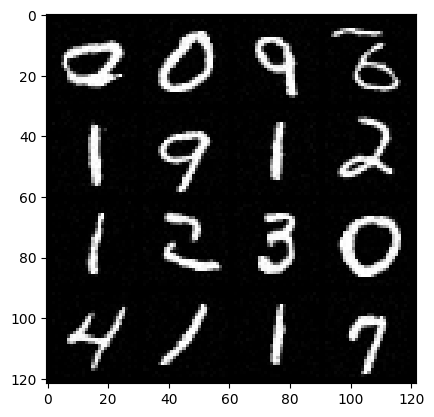

In [13]:
model = DiffusionModel.load_from_checkpoint('checkpoints/diffusion-epoch=44-train_loss=0.0138.ckpt', map_location=device)
out = model.generate_samples(deterministic=False)
grid = make_grid(out, nrow=4, normalize=True)
grid = grid.cpu().permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.show()

And also we can visualise process of denoising sample:

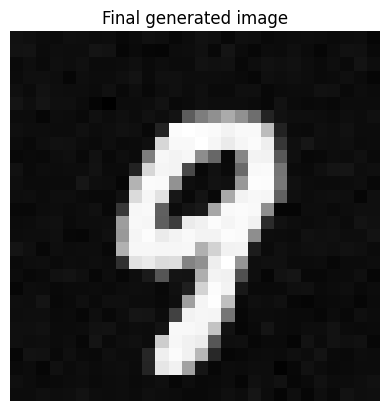

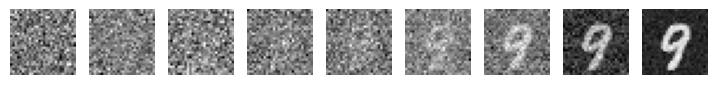

In [14]:
def display_reverse(images: List[torch.Tensor]):
    fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0).permute(1, 2, 0).cpu().numpy()
        ax.imshow(x, cmap='gray')
        ax.axis('off')
    plt.show()


def inference(checkpoint: str, num_time_steps: int = 1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DiffusionModel.load_from_checkpoint(checkpoint, map_location=device)
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    images = []

    with torch.no_grad():
        model = model.eval()
        x = torch.randn(1, 1, 28, 28).to(device)
        for t in reversed(range(1, num_time_steps)):
            t_tensor = torch.tensor([t], device=x.device).repeat(1)
            beta_t = scheduler.beta.to(device)[t_tensor].view(1, 1, 1, 1)
            alpha_t = scheduler.alpha.to(device)[t_tensor].view(1, 1, 1, 1)
            temp = beta_t / (torch.sqrt(1 - alpha_t) * torch.sqrt(1 - beta_t))

            x = (1 / torch.sqrt(1 - beta_t)) * x - (temp * model.model(x, t_tensor))
            e = torch.randn_like(x)
            x = x + e * torch.sqrt(beta_t)

            if t in times:
                images.append(x.clone().detach().cpu())

    final_img = x.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(final_img, cmap='gray')
    plt.title("Final generated image")
    plt.axis('off')
    plt.show()

    display_reverse(list(images))

inference("checkpoints/diffusion-epoch=44-train_loss=0.0138.ckpt")

### Conditional Diffusion Model — adding control to generation

If everything has been implemented correctly, we should now be able to generate **clear images of digits** 🎉  
That completes our **basic Diffusion Model**!

---

### Why conditional diffusion?

In our current setup, sampling starts from **pure noise** — so each generated image is **completely random**.  
We have no control over what kind of image appears at the output.

To fix this, we can introduce **conditioning information**, such as a class label or a text embedding, that guides the denoising process toward a specific type of output.  
For example:
- Generating a **digit “7”** in MNIST, or  
- Creating a **cat** image instead of a **dog**, or  
- Using a **text prompt** like *“a sunset over the mountains”* in **Stable Diffusion**.

This approach is called a **Conditional Diffusion Model** — the model learns to condition its generation on an additional input (class, text, or latent embedding).

---

### Real-world example: Stable Diffusion

Let’s look at how this concept scales to larger, real-world text-to-image models such as [**Stable Diffusion**](https://stablediffusionweb.com/).

Even though implementations differ, most modern conditional diffusion systems share **three core components**:

1. **Text Encoder** — transforms text into embeddings that condition image generation.  
   - Example: [**CLIP**](https://github.com/openai/CLIP) from OpenAI, which aligns text and image embeddings using Transformer encoders.  
   - The output embedding serves as a *conditioning vector* for the diffusion model.

2. **U-Net Denoising Model** — performs iterative denoising in latent space.  
   - This is essentially our **U-Net**, but often extended with **cross-attention layers** to incorporate conditioning information (e.g., from text).

3. **Variational Autoencoder (VAE)** — encodes high-resolution images into a smaller **latent space**, reducing memory and computation.  
   - The diffusion process operates in this compressed latent space.  
   - The final decoded result is obtained by running the **VAE decoder**.

These three parts together allow for **efficient**, **high-resolution**, and **text-controlled** generation.

---

### Our simplified conditional model

Since training a full-scale Stable Diffusion model is resource-intensive, we can instead **adapt our current diffusion model** to accept conditioning signals.  
We’ll focus on adding **Cross-Attention** layers — a mechanism that lets the model *attend* to an external embedding (e.g. class label or text feature).

---

### `CrossAttentionBlock` — fusing conditioning information

This block works similarly to our standard `AttentionBlock`, but with a few key modifications:

1. We now have **separate channel dimensions** for queries (`C_q`) and for keys/values (`C_kv`).  
2. The `key` and `value` linear layers map from `C_kv → C_q`, while `query` maps from `C_q → C_q`.  
3. We **do not** use normalization here.  
4. We **flatten only the query input** (`x_q`), while the conditioning input (`x_kv`) is already in the correct shape.  
5. Each of the query, key, and value tensors is projected through its corresponding `Linear` layer.  
6. We reshape them for multi-head attention based on their respective sequence lengths `L_q` and `L_ctx`.  
7. We apply `F.scaled_dot_product_attention`, just as before, followed by recombining the heads and a final linear projection.


In [15]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, C_q: int, C_kv: int, num_heads: int, dropout_p: float):
        super().__init__()
        assert C_q % num_heads == 0, "C_q must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = C_q // num_heads
        self.dropout_p = dropout_p

        # Linear projections for query (from image) and key/value (from embeddings)
        self.query = nn.Linear(C_q, C_q)    # Query: from image features
        self.key = nn.Linear(C_kv, C_q)     # Key: from conditional embeddings
        self.value = nn.Linear(C_kv, C_q)   # Value: from conditional embeddings

        # Output projection after attention
        self.proj_out = nn.Linear(C_q, C_q)

    def forward(self, x_q, x_kv):
        """
        Args:
            x_q: (B, C_q, H, W) - query feature map
            x_kv: (B, L_ctx, C_kv) - contextual embeddings (e.g., class embeddings)
        Returns:
            out: (B, C_q, H, W)
        """
        B, Cq, H, W = x_q.shape
        B, L_ctx, Ckv = x_kv.shape

        # Flatten spatial dims of query: (B, Cq, H, W) -> (B, L_q, Cq)
        q = x_q.view(B, Cq, H * W).permute(0, 2, 1)
        L_q = q.shape[1]

        # Project Q, K, V
        q = self.query(q)  # (B, L_q, C_q)
        k = self.key(x_kv)  # (B, L_ctx, C_q)
        v = self.value(x_kv)  # (B, L_ctx, C_q)

        # Reshape for multi-head attention
        q = q.view(B, L_q, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, H, L_q, d)
        k = k.view(B, L_ctx, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, H, L_ctx, d)
        v = v.view(B, L_ctx, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, H, L_ctx, d)

        # Scaled dot-product attention
        attn = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout_p, is_causal=False
        )  # (B, H, L_q, d)

        # Merge heads back together
        attn = attn.permute(0, 2, 1, 3).contiguous().view(B, L_q, Cq)  # (B, L_q, C_q)

        # Final projection and reshape back to (B, C_q, H, W)
        out = self.proj_out(attn)
        out = out.permute(0, 2, 1).reshape(B, Cq, H, W)

        return out


We introduce this inside MidBlock2D, right after AttentionBlock.

Define `CrossMidBlock2D` with additional `CrossAttentionBlock` with parameter `C_cls`. In forward use it after `self.attn` and remember to use `emb.cls.unsqueeze(1)`. Output of this Cross Attention goes to second ResNetBlock.

In [16]:
class CrossMidBlock2D(nn.Module):
    def __init__(self, C, 
                        C_emb, 
                        C_cls,
                        num_groups, 
                        dropout_p):
        
        super().__init__()
        self.res1 = ResnetBlock2D(C,   C,   C_emb, num_groups, dropout_p)
        self.attn = AttentionBlock(C, num_heads=8, num_groups=num_groups, dropout_p=dropout_p)
        self.cross_attn = CrossAttentionBlock(C, C_cls, num_heads=8, dropout_p=dropout_p)
        self.res2 = ResnetBlock2D(C,   C,   C_emb, num_groups, dropout_p)

    def forward(self, x, emb, emb_cls):
        x = self.res1(x, emb)
        x = self.attn(x)
        x = self.cross_attn(x, emb_cls.unsqueeze(1))
        x = self.res2(x, emb)
        return x

We now define our `ConditionalUNET`, which inherits from the `UNET` class.  
In the `__init__` method, we replace the `mid` layer with our new `CrossMidBlock2D` **(cls and time embeddings size are equal to `C_emb`)**, and additionally define an `nn.Embedding` layer with 10 classes (since we are using the MNIST dataset) that maps class labels to the same embedding dimension `C_emb`.

In the `forward` method, we add:

```python
emb_cls = self.cls_embeddings(cls.to(x.device))
```

and modify the bottleneck call to:

```python
h = self.mid(h, emb, emb_cls)
```



In [17]:
class ConditionalUNET(UNET):
    def __init__(self,
                 input_channels: int = 1,
                 time_steps: int = 1000,
                 base: int = 128,
                 C_emb = 512,
                 num_groups: int = 32,
                 dropout_prob: float = 0.1):
        super().__init__(input_channels=input_channels,
                 time_steps=time_steps,
                 base=base,
                 C_emb = C_emb,
                 num_groups=num_groups,
                 dropout_prob=dropout_prob)

        # Cls/step embeddings
        self.cls_embeddings = nn.Embedding(10, C_emb)
        self.mid = CrossMidBlock2D(base * 4, C_emb, C_emb, num_groups, dropout_prob)

    def forward(self, x, t, cls):
        """
        x: (B, input_channels, H, W)
        t: (B,) integer timesteps compatible with SinusoidalEmbeddings
        """
        B, _, H, W = x.shape
        h = self.conv_in(x)
        emb = self.embeddings(t).to(h.device)
        emb_cls = self.cls_embeddings(cls.to(x.device))

        # ---------- Down path (encoder) ----------
        h, skip1 = self.down1(h, emb)   # (B, base, H/2, W/2)
        h, skip2 = self.down2(h, emb)   # (B, 2*base, H/4, W/4)
        h, skip3 = self.down3(h, emb)   # (B, 4*base, H/8, W/8)

        # ---------- Bottleneck ----------
        h = self.mid(h, emb, emb_cls)

        # ---------- Up path (decoder) ----------
        h = self.up1(h, skip3, emb)     # (B, 2*base, H/4, W/4)
        h = self.up2(h, skip2, emb)     # (B, base, H/2, W/2)
        h = self.up3(h, skip1, emb)     # (B, base, H, W)

        # ---------- Output ----------
        h = self.norm_out(h)
        h = self.nonlinear(h)
        out = self.conv_out(h)
        return out

And also we define the `ConditionalDiffusionModel` which simply use `y` values from MNIST dataset or arrange in sampling method inside model as additional parameter.

In [18]:
class ConditionalDiffusionModel(L.LightningModule):
    def __init__(self,
                 in_channels: int = 1,
                 img_shape: Tuple = (28, 28),
                 num_time_steps: int = 1000,
                 lr: float = 2e-5):
        super().__init__()
        self.save_hyperparameters()

        self.in_channels = in_channels
        self.num_time_steps = num_time_steps
        self.img_shape = img_shape

        self.model = ConditionalUNET(input_channels=in_channels, time_steps=num_time_steps)
        self.scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
        self.criterion = nn.MSELoss(reduction='mean')
        self.lr = lr

        self.register_buffer("fixed_noise", torch.randn(16, in_channels, *img_shape))
        self.register_buffer("fixed_noise_seq", torch.randn(num_time_steps, 16, in_channels, *img_shape))


    def training_step(self, batch, batch_idx):
        x, y = batch
        B = x.size(0)
        t = torch.randint(0, self.num_time_steps, (B,), device=self.device)
        e = torch.randn_like(x)
        a = self.scheduler.alpha.to(self.device)[t].view(B, 1, 1, 1)
        x_noisy = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)

        output = self.model(x_noisy, t, y)
        loss = self.criterion(output, e)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=1e-4
        )

        # Cosine annealing scheduler (smoothly decreases LR during training)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=self.lr * 0.1
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1,
            },
        }


    @torch.no_grad()
    def generate_samples(self, n_samples=16, num_time_steps=1000, deterministic=True, y=None):
        self.model.eval()

        if deterministic:
            z = self.fixed_noise.clone().to(self.device)
        else:
            z = torch.randn(n_samples, self.in_channels, *self.img_shape).to(self.device)

        scheduler = self.scheduler

        if y is None:
            y = torch.arange(n_samples, device=self.device) % 10

        for t in reversed(range(1, num_time_steps)):
            t_tensor = torch.tensor([t], device=z.device).repeat(n_samples)
            beta_t = scheduler.beta.to(self.device)[t_tensor].view(n_samples, 1, 1, 1)
            alpha_t = 1 - beta_t
            hat_alpha_t = scheduler.alpha.to(self.device)[t_tensor].view(n_samples, 1, 1, 1)

            # Predict noise with the model
            eps_theta = self.model(z, t_tensor, y)

            # Reverse diffusion update (deterministic part)
            z = (1 / torch.sqrt(alpha_t)) * (
                z - ((1 - alpha_t) / torch.sqrt(1 - hat_alpha_t)) * eps_theta
            )

            if deterministic:
                e = self.fixed_noise_seq[t].clone().to(self.device)
            else:
                e = torch.randn_like(z)

            z = z + e * torch.sqrt(beta_t)
        return z.clamp(0, 1)


    def on_train_epoch_end(self):
        """Log generated samples to W&B every few epochs"""
        y = torch.arange(16, device=self.device) % 10  # sample classes 0–9
        imgs = self.generate_samples(n_samples=16, y=y)
        grid = make_grid(imgs, nrow=4, normalize=True)
        self.logger.experiment.log({
            "generated_samples": [wandb.Image(grid, caption=f"Epoch {self.current_epoch+1}")]
        })


We now train our conditional model.  
Although we could load the previously trained (unconditional) model weights, training this version from scratch is fast enough — especially on the MNIST dataset — so we’ll simply retrain it entirely.

In [19]:
batch_size = 64
num_workers = 16
num_time_steps = 1000
lr = 2e-5

# Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

# W&B logger
wandb_logger = WandbLogger(project="lab8-diffusion", 
                           entity="deep-neural-network-course",
                           group="conditional-diffusion-model",
                           name="Karolina Piotrowska",
                           log_model=True)

# Model + Trainer setup
model = ConditionalDiffusionModel(num_time_steps=num_time_steps, lr=lr)

checkpoint_callback = ModelCheckpoint(
        dirpath="./checkpoints",
        filename="conditional-diffusion-{epoch:02d}-{train_loss:.4f}",
        save_top_k=1,
        monitor="train_loss",
        mode="min"
    )

trainer = L.Trainer(
    max_epochs=5,
    precision="16-mixed",
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=50
)

trainer.fit(model, train_loader)
wandb.finish()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/karolina/studia/gsn/venv/lib/python3.12/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off prec

/home/karolina/studia/gsn/venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /home/karolina/studia/gsn/lab6/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/karolina/studia/gsn/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | ConditionalUNET | 36.9 M | train
1 | scheduler | DDPM_Scheduler  | 0      | train
2 | criterion | MSELoss         | 0      | train
------------------------------------------------------
36.9 M    Trainable params
0         Non-trainable params
36.9 M    Total params
147.508   Total estimated model params size (MB)
167       Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 937/937 [01:48<00:00,  8.66it/s, v_num=e1nt, train_loss_step=0.0144, train_loss_epoch=0.0176] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 937/937 [02:03<00:00,  7.59it/s, v_num=e1nt, train_loss_step=0.0144, train_loss_epoch=0.0176]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████████
train_loss_epoch,█▂▁▁▁
train_loss_step,█▇▆▇▄▄▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▂▁▂▁▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
epoch,4
train_loss_epoch,0.01758
train_loss_step,0.01759
trainer/global_step,4684


Load conditional model weights and test result on defined `y` tensor.

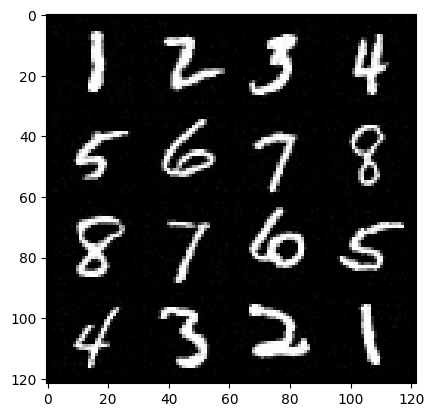

In [20]:
model = ConditionalDiffusionModel.load_from_checkpoint('checkpoints/conditional-diffusion-epoch=49-train_loss=0.0132.ckpt', map_location=device)
y = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 1], device=device)
out = model.generate_samples(deterministic=False, y=y)
grid = make_grid(out, nrow=4, normalize=True)
grid = grid.cpu().permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.show()